In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv002.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [2]:
import sys, os, tqdm
import numpy as np
import xarray as xr
import torch

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

sys.path.append('../../mre_ai')
#import mre_ai.mre_datasets

torch.cuda.is_available()

Using backend: pytorch



True

## Process images for a single patient

- load SITK images from NIFIT files
- perform filtering/inpainting on wave image
- register images wrt anatomical image
- load segmentation model
- perform image segmentation
- convert images to xarray Dataset

In [159]:
%autoreload
patient = mre_pinn.data.Patient(
    nifti_dir='/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI',
    patient_id='0006',
    sequences=['t1_pre_out', 'mre_raw', 'wave', 'mre'],
    xarray_dir='../data/NAFLD_test/'
)
patient.load_images()
patient.metadata

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/mre.nii


size    spacing      origin       limit      center  \
sequence   dimension                                                        
t1_pre_out 0           512   0.703100 -204.130005  155.154108  -24.487948   
           1           512   0.703100 -208.591995  150.692118  -28.949939   
           2            88   2.300003 -142.013000   58.087265  -41.962868   
mre_raw    0           256   1.406300 -206.904007  151.702480  -27.600763   
           1           256   1.406300 -195.858994  162.747493  -16.555750   
           2             4   1.000000    0.000000    3.000000    1.500000   
wave       0           512   1.000000    0.000000  511.000000  255.500000   
           1           512   1.000000    0.000000  511.000000  255.500000   
           2             4   1.000000    0.000000    3.000000    1.500000   
mre        0           256   1.406300 -206.904007  151.702480  -27.600763   
           1           256   1.406300 -195.858994  162.747493  -16.555750   
           2             4  11.000000   -1.056400   31.943600   15.443600   

                          extent  
sequence   dimension              
t1_pre_out 0          359.987213  
           1          359.987213  
           2          202.400269  
mre_raw    0          360.012787  
           1          360.012787  
           2            4.000000  
wave       0          512.000000  
           1          512.000000  
           2            4.000000  
mre        0          360.012787  
           1          360.012787  
           2           44.000000

In [160]:
%autoreload
patient.preprocess_images()

Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
ParameterObject (0x55cc4dddc9e0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 29242505
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -27.6008 -16.5558 15.4436)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -207.243 -196.198 -84.6065)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 88)
  (Spacing 0.7031 0.703

In [161]:
patient.metadata

size    spacing      origin       limit     center  \
sequence   dimension                                                       
t1_pre_out 0           512   0.703100 -207.242820  152.041293 -27.600763   
           1           512   0.703100 -196.197807  163.086306 -16.555750   
           2            88   2.300003  -84.606533  115.493733  15.443600   
mre_raw    0           256   1.406300 -206.904007  151.702480 -27.600763   
           1           256   1.406300 -195.858994  162.747493 -16.555750   
           2             4  11.000000   -1.056400   31.943600  15.443600   
wave       0           512   0.703150 -207.255582  152.054055 -27.600763   
           1           512   0.703150 -196.210569  163.099068 -16.555750   
           2             4  11.000000   -1.056400   31.943600  15.443600   
mre        0           256   1.406300 -206.904007  151.702480 -27.600763   
           1           256   1.406300 -195.858994  162.747493 -16.555750   
           2             4  11.000000   -1.056400   31.943600  15.443600   

                          extent  
sequence   dimension              
t1_pre_out 0          359.987213  
           1          359.987213  
           2          202.400269  
mre_raw    0          360.012787  
           1          360.012787  
           2           44.000000  
wave       0          360.012787  
           1          360.012787  
           2           44.000000  
mre        0          360.012787  
           1          360.012787  
           2           44.000000

Converting t1_pre_out to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray


<IPython.core.display.Javascript object>


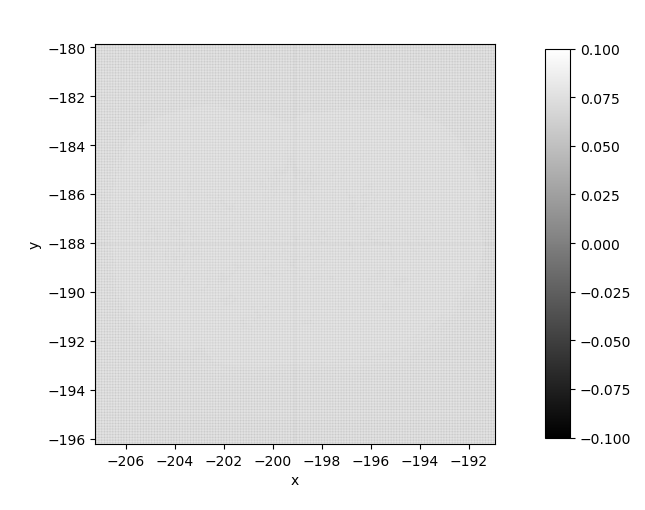

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [167]:
%autoreload
patient.view(compare=True)

In [81]:
%autoreload
patient.save_xarrays()

Writing ../data/NAFLD_test/0006/t1_pre_in.nc
Writing ../data/NAFLD_test/0006/t1_pre_water.nc
Writing ../data/NAFLD_test/0006/t1_pre_out.nc
Writing ../data/NAFLD_test/0006/t1_pre_fat.nc
Writing ../data/NAFLD_test/0006/t2.nc
Writing ../data/NAFLD_test/0006/mre_raw.nc
Writing ../data/NAFLD_test/0006/wave.nc
Writing ../data/NAFLD_test/0006/mre.nc
Writing ../data/NAFLD_test/0006/mask.nc


In [82]:
patient.load_xarrays()

Loading ../data/NAFLD_test/0006/t1_pre_in.nc
Loading ../data/NAFLD_test/0006/t1_pre_water.nc
Loading ../data/NAFLD_test/0006/t1_pre_out.nc
Loading ../data/NAFLD_test/0006/t1_pre_fat.nc
Loading ../data/NAFLD_test/0006/t2.nc
Loading ../data/NAFLD_test/0006/mre_raw.nc
Loading ../data/NAFLD_test/0006/wave.nc
Loading ../data/NAFLD_test/0006/mre.nc
Loading ../data/NAFLD_test/0006/mask.nc


## Process images for a patient cohort

In [4]:
%ls /ocean/projects/asc170022p/shared/Data/MRE/*/NIFTI/ -d

/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI//
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI//
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI//
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI//


In [8]:
%cat /ocean/projects/asc170022p/shared/Data/MRE/gold.txt

xarray_0006.nc
xarray_0020.nc
xarray_0024.nc
xarray_0029.nc
xarray_0043.nc
xarray_0047.nc
xarray_0126.nc
xarray_0135.nc
xarray_0155.nc
xarray_0164.nc
xarray_0172.nc
xarray_0173.nc
xarray_0210.nc
xarray_0213.nc
xarray_0219.nc
xarray_0222.nc
xarray_0234.nc
xarray_0235.nc
xarray_0291.nc
xarray_0344.nc
xarray_0378.nc
xarray_0384.nc
xarray_0395.nc
xarray_0401.nc
xarray_0415.nc
xarray_0457.nc
xarray_0461.nc
xarray_0491.nc
xarray_0492.nc
xarray_0496.nc
xarray_0509.nc
xarray_0510.nc
xarray_0516.nc
xarray_0525.nc
xarray_0564.nc
xarray_0604.nc
xarray_0612.nc
xarray_0615.nc
xarray_0628.nc
xarray_0639.nc
xarray_0648.nc
xarray_0650.nc
xarray_0653.nc
xarray_0655.nc
xarray_0659.nc
xarray_0693.nc
xarray_0704.nc
xarray_0717.nc
xarray_0727.nc
xarray_0734.nc
xarray_0737.nc
xarray_0740.nc
xarray_0747.nc
xarray_0748.nc
xarray_0830.nc
xarray_0838.nc
xarray_0846.nc
xarray_0860.nc
xarray_0872.nc
xarray_0898.nc
xarray_0900.nc
xarray_0929.nc
xarray_0931.nc
xarray_0932.nc
xarray_0940.nc
xarray_0954.nc
xarray_096

In [6]:
with open('/ocean/projects/asc170022p/shared/Data/MRE/gold.txt') as f:
    patient_ids = [line.split('.')[0].split('_')[1] for line in f]

len(patient_ids)

181

In [33]:
%autoreload
cohort = mre_pinn.data.PatientCohort(
    nifti_dirs='/ocean/projects/asc170022p/shared/Data/MRE/*/NIFTI',
    patient_ids='{' + ','.join(patient_ids) + '}',
    xarray_dir='../data/NAFLD/'
)
len(cohort)

/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0830 is missing sequences {'wave'}
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0838 is missing sequences {'wave'}
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0846 is missing sequences {'wave'}
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0860 is missing sequences {'wave'}
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0872 is missing sequences {'wave'}
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1474 is missing sequences {'wave'}
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1483 is missing sequences {'wave'}
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1495 is missing sequences {'wave'}
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1504 is missing sequences {'wave'}
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1526 

155

In [34]:
%%time
cohort.load_images()

  0%|          | 0/155 [00:00<?, ?it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/mre.nii
  1%|          | 1/155 [00:02<06:35,  2.57s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0900/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFT

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0989/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0989/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0989/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0989/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0989/mre.nii
  7%|▋         | 11/155 [00:16<03:00,  1.25s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0995/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0995/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0995/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0995/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0995/t2.nii
Loading /ocean/projects

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1103/mre.nii
 14%|█▎        | 21/155 [00:26<02:23,  1.07s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/mre.nii
 14%|█▍        | 22/155 [00:27<02:26,  1.10s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1207/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1207/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1207/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1207/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1207/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1207/mre.nii
 21%|██        | 32/155 [00:40<02:38,  1.29s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1215/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1215/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1215/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1215/t1_pre_fat.nii
Loading /ocean/

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1337/mre.nii
 27%|██▋       | 42/155 [00:50<01:58,  1.05s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/mre.nii
 28%|██▊       | 43/155 [00:51<02:17,  1.23s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1433/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1433/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1433/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1433/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1433/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1433/mre.nii
 34%|███▍      | 53/155 [01:03<01:50,  1.08s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1435/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1435/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1435/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1435/t1_pre_fat.nii
Loading /ocean/

 41%|████      | 63/155 [01:13<01:31,  1.01it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0047/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0047/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0047/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0047/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0047/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0047/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0047/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0047/mre.nii
 41%|████▏     | 64/155 [01:14<01:34,  1.03s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0126/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFT

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0384/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0384/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0384/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0384/mre.nii
 48%|████▊     | 74/155 [01:23<01:15,  1.07it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0395/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0395/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0395/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0395/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0395/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0395/mre_raw.nii
Loading /ocean/projects/asc170022p/s

 54%|█████▍    | 84/155 [01:33<01:07,  1.06it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0235/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0235/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0235/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0235/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0235/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0235/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0235/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0235/mre.nii
 55%|█████▍    | 85/155 [01:34<01:09,  1.00it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0457/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFT

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0564/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0564/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0564/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0564/mre.nii
 61%|██████▏   | 95/155 [01:44<00:56,  1.07it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0604/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0604/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0604/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0604/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0604/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0604/mre_raw.nii
Loading /ocean/projects/asc170022p/s

 68%|██████▊   | 105/155 [01:54<00:47,  1.06it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0693/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0693/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0693/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0693/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0693/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0693/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0693/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0693/mre.nii
 68%|██████▊   | 106/155 [01:55<00:53,  1.10s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0704/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NI

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1679/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1679/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1679/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1679/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1679/mre.nii
 75%|███████▍  | 116/155 [02:06<00:48,  1.25s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1694/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1694/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1694/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1694/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1694/t2.nii
Loading /ocean/projects/asc17002

 81%|████████▏ | 126/155 [02:18<00:31,  1.09s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1748/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1748/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1748/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1748/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1748/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1748/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1748/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1748/mre.nii
 82%|████████▏ | 127/155 [02:18<00:27,  1.00it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1785/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NI

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1819/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1819/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1819/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1819/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1819/mre.nii
 88%|████████▊ | 137/155 [02:28<00:18,  1.01s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1829/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1829/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1829/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1829/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1829/t2.nii
Loading /ocean/projects/asc17002

 95%|█████████▍| 147/155 [02:38<00:07,  1.06it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1940/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1940/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1940/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1940/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1940/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1940/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1940/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1940/mre.nii
 95%|█████████▌| 148/155 [02:39<00:06,  1.05it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1948/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NI

In [35]:
%%time
m = cohort.metadata
m

CPU times: user 2.52 s, sys: 42.6 ms, total: 2.56 s
Wall time: 4.09 s


size    spacing      origin       limit  \
patient_id sequence     dimension                                            
0898       t1_pre_in    0           512   0.820300 -193.358994  225.814298   
                        1           512   0.820300 -265.899994  153.273297   
                        2           120   2.300003  -64.173203  209.527161   
           t1_pre_water 0           512   0.820300 -193.358994  225.814298   
                        1           512   0.820300 -265.899994  153.273297   
...                                 ...        ...         ...         ...   
2046       wave         1           512   1.000000    0.000000  511.000000   
                        2             4   1.000000    0.000000    3.000000   
           mre          0           256   1.484400 -173.035995  205.486013   
                        1           256   1.484400 -209.257996  169.264013   
                        2             4  11.000000  -92.152802  -59.152802   

                                       center      extent  
patient_id sequence     dimension                          
0898       t1_pre_in    0           16.227652  419.993591  
                        1          -56.313348  419.993591  
                        2           72.676979  276.000366  
           t1_pre_water 0           16.227652  419.993591  
                        1          -56.313348  419.993591  
...                                       ...         ...  
2046       wave         1          255.500000  512.000000  
                        2            1.500000    4.000000  
           mre          0           16.225009  380.006409  
                        1          -19.996991  380.006409  
                        2          -75.652802   44.000000  

[3720 rows x 6 columns]

In [37]:
(m.reset_index().groupby(['patient_id', 'sequence']).dimension.count() == 3) \
    .reset_index().groupby(['patient_id']).dimension.all().all()

True

In [40]:
%%time
cohort.create_xarrays()

Loading segmentation model
  0%|          | 0/155 [00:00<?, ?it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Resizing t1_pre_in to (256, 256, 32)
Resizing t1_pre_water to (256, 256, 32)
Resizing t1_pre_out to (256, 256, 32)


Resizing t1_pre_in to (256, 256, 32)
Resizing t1_pre_water to (256, 256, 32)
Resizing t1_pre_out to (256, 256, 32)
Resizing t1_pre_fat to (256, 256, 32)
Resizing t2 to (256, 256, 32)
Resizing mre_raw to (256, 256, 32)
Resizing wave to (256, 256, 32)
Resizing mre to (256, 256, 32)
Segmenting t1_pre_out
Registering t1_pre_in to mre_raw
Registering t1_pre_water to mre_raw
Registering t1_pre_out to mre_raw
Registering t1_pre_fat to mre_raw
Registering t2 to mre_raw
Transforming mask
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
  4%|▍         | 6/155 [02:04<45:00, 18.13s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0954/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0954/t1_pre_water.nii
Loading /ocean/pr

Resizing t2 to (256, 256, 32)
Resizing mre_raw to (256, 256, 32)
Resizing wave to (256, 256, 32)
Resizing mre to (256, 256, 32)
Segmenting t1_pre_out
Registering t1_pre_in to mre_raw
Registering t1_pre_water to mre_raw
Registering t1_pre_out to mre_raw
Registering t1_pre_fat to mre_raw
Registering t2 to mre_raw
Transforming mask
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
  7%|▋         | 11/155 [03:28<40:48, 17.01s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0995/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0995/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0995/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIF

Registering t1_pre_water to mre_raw
Registering t1_pre_out to mre_raw
Registering t1_pre_fat to mre_raw
Registering t2 to mre_raw
Transforming mask
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
 10%|█         | 16/155 [04:51<38:47, 16.75s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1075/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1075/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1075/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1075/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1075/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NI

 14%|█▎        | 21/155 [06:15<37:26, 16.76s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Resizing t1_pre_in to (256, 256, 32)
Resizing t1_pre_water to (256, 256, 32)
Resizing t1_pre_out to (256, 256, 32)
Resizing t1_pre_fa

Resizing t1_pre_in to (256, 256, 32)
Resizing t1_pre_water to (256, 256, 32)
Resizing t1_pre_out to (256, 256, 32)
Resizing t1_pre_fat to (256, 256, 32)
Resizing t2 to (256, 256, 32)
Resizing mre_raw to (256, 256, 32)
Resizing wave to (256, 256, 32)
Resizing mre to (256, 256, 32)
Segmenting t1_pre_out
Registering t1_pre_in to mre_raw
Registering t1_pre_water to mre_raw
Registering t1_pre_out to mre_raw
Registering t1_pre_fat to mre_raw
Registering t2 to mre_raw
Transforming mask
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
 17%|█▋        | 27/155 [07:57<35:55, 16.84s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1134/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1134/t1_pre_water.nii
Loading /ocean/p

Resizing mre to (256, 256, 32)
Segmenting t1_pre_out
Registering t1_pre_in to mre_raw
Registering t1_pre_water to mre_raw
Registering t1_pre_out to mre_raw
Registering t1_pre_fat to mre_raw
Registering t2 to mre_raw
Transforming mask
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
 21%|██        | 32/155 [09:21<34:34, 16.86s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1215/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1215/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1215/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1215/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFT

Registering t1_pre_fat to mre_raw
Registering t2 to mre_raw
Transforming mask
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
 24%|██▍       | 37/155 [10:45<32:58, 16.77s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1303/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1303/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1303/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1303/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1303/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1303/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MR

 27%|██▋       | 42/155 [12:08<31:25, 16.69s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Resizing t1_pre_in to (256, 256, 32)
Resizing t1_pre_water to (256, 256, 32)
Resizing t1_pre_out to (256, 256, 32)
Resizing t1_pre_fa

Resizing t1_pre_in to (256, 256, 32)
Resizing t1_pre_water to (256, 256, 32)
Resizing t1_pre_out to (256, 256, 32)
Resizing t1_pre_fat to (256, 256, 32)
Resizing t2 to (256, 256, 32)
Resizing mre_raw to (256, 256, 32)
Resizing wave to (256, 256, 32)
Resizing mre to (256, 256, 32)
Segmenting t1_pre_out
Registering t1_pre_in to mre_raw
Registering t1_pre_water to mre_raw
Registering t1_pre_out to mre_raw
Registering t1_pre_fat to mre_raw
Registering t2 to mre_raw
Transforming mask
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
 31%|███       | 48/155 [13:48<29:29, 16.53s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1404/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1404/t1_pre_water.nii
Loading /ocean/p

Resizing t2 to (256, 256, 32)
Resizing mre_raw to (256, 256, 32)
Resizing wave to (256, 256, 32)
Resizing mre to (256, 256, 32)
Segmenting t1_pre_out
Registering t1_pre_in to mre_raw
Registering t1_pre_water to mre_raw
Registering t1_pre_out to mre_raw
Registering t1_pre_fat to mre_raw
Registering t2 to mre_raw
Transforming mask
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
 34%|███▍      | 53/155 [15:12<28:39, 16.85s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1435/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1435/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1435/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIF

Registering t1_pre_water to mre_raw
Registering t1_pre_out to mre_raw
Registering t1_pre_fat to mre_raw
Registering t2 to mre_raw
Transforming mask
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
 37%|███▋      | 58/155 [16:35<27:00, 16.71s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/00

 41%|████      | 63/155 [17:59<25:31, 16.64s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0047/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0047/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0047/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0047/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0047/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0047/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0047/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0047/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Resizing t1_pre_in to (256, 256, 32)
Resizing t1_pre_water to (256, 256, 32)
Resizing t1_pre_out to (256, 256, 32)
Resizing t1_pre_fat to (25

Resizing t1_pre_in to (256, 256, 32)
Resizing t1_pre_water to (256, 256, 32)
Resizing t1_pre_out to (256, 256, 32)
Resizing t1_pre_fat to (256, 256, 32)
Resizing t2 to (256, 256, 32)
Resizing mre_raw to (256, 256, 32)
Resizing wave to (256, 256, 32)
Resizing mre to (256, 256, 32)
Segmenting t1_pre_out
Registering t1_pre_in to mre_raw
Registering t1_pre_water to mre_raw
Registering t1_pre_out to mre_raw
Registering t1_pre_fat to mre_raw
Registering t2 to mre_raw
Transforming mask
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
 45%|████▍     | 69/155 [19:47<25:14, 17.61s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0173/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0173/t1_pre_water.nii
Loading /ocean/pro

Resizing mre to (256, 256, 32)
Segmenting t1_pre_out
Registering t1_pre_in to mre_raw
Registering t1_pre_water to mre_raw
Registering t1_pre_out to mre_raw
Registering t1_pre_fat to mre_raw
Registering t2 to mre_raw
Transforming mask
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
 48%|████▊     | 74/155 [21:44<27:10, 20.13s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0395/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0395/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0395/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0395/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/039

Registering t2 to mre_raw
Transforming mask
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
 51%|█████     | 79/155 [23:08<21:58, 17.34s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0210/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0210/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0210/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0210/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0210/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0210/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0210/wave.nii


 54%|█████▍    | 84/155 [24:32<19:59, 16.90s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0235/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0235/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0235/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0235/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0235/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0235/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0235/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0235/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Resizing t1_pre_in to (256, 256, 32)
Resizing t1_pre_water to (256, 256, 32)
Resizing t1_pre_out to (256, 256, 32)
Resizing t1_pre_fat to (25

Resizing t1_pre_in to (256, 256, 32)
Resizing t1_pre_water to (256, 256, 32)
Resizing t1_pre_out to (256, 256, 32)
Resizing t1_pre_fat to (256, 256, 32)
Resizing t2 to (256, 256, 32)
Resizing mre_raw to (256, 256, 32)
Resizing wave to (256, 256, 32)
Resizing mre to (256, 256, 32)
Segmenting t1_pre_out
Registering t1_pre_in to mre_raw
Registering t1_pre_water to mre_raw
Registering t1_pre_out to mre_raw
Registering t1_pre_fat to mre_raw
Registering t2 to mre_raw
Transforming mask
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
 58%|█████▊    | 90/155 [26:21<19:51, 18.34s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0509/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0509/t1_pre_water.nii
Loading /ocean/pro

Segmenting t1_pre_out
Registering t1_pre_in to mre_raw
Registering t1_pre_water to mre_raw
Registering t1_pre_out to mre_raw
Registering t1_pre_fat to mre_raw
Registering t2 to mre_raw
Transforming mask
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
 61%|██████▏   | 95/155 [27:45<17:03, 17.05s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0604/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0604/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0604/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0604/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0604/t2.nii
Loading /ocean/project

Transforming mask
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
 65%|██████▍   | 100/155 [29:08<15:18, 16.70s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0648/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0648/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0648/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0648/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0648/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0648/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0648/wave.nii
Loading /ocean/projects/a

 68%|██████▊   | 105/155 [30:32<14:03, 16.87s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0693/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0693/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0693/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0693/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0693/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0693/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0693/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0693/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Resizing t1_pre_in to (256, 256, 32)
Resizing t1_pre_water to (256, 256, 32)
Resizing t1_pre_out to (256, 256, 32)
Resizing t1_pre_fat to (2

Resizing t1_pre_in to (256, 256, 32)
Resizing t1_pre_water to (256, 256, 32)
Resizing t1_pre_out to (256, 256, 32)
Resizing t1_pre_fat to (256, 256, 32)
Resizing t2 to (256, 256, 32)
Resizing mre_raw to (256, 256, 32)
Resizing wave to (256, 256, 32)
Resizing mre to (256, 256, 32)
Segmenting t1_pre_out
Registering t1_pre_in to mre_raw
Registering t1_pre_water to mre_raw
Registering t1_pre_out to mre_raw
Registering t1_pre_fat to mre_raw
Registering t2 to mre_raw
Transforming mask
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
 72%|███████▏  | 111/155 [32:13<12:18, 16.77s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0740/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0740/t1_pre_water.nii
Loading /ocean/pr

Segmenting t1_pre_out
Registering t1_pre_in to mre_raw
Registering t1_pre_water to mre_raw
Registering t1_pre_out to mre_raw
Registering t1_pre_fat to mre_raw
Registering t2 to mre_raw
Transforming mask
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
 75%|███████▍  | 116/155 [33:53<13:09, 20.24s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1694/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1694/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1694/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1694/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1694/t2.nii
Loading /ocean/projec

Transforming mask
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
 78%|███████▊  | 121/155 [35:19<09:59, 17.64s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1715/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1715/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1715/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1715/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1715/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1715/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1715/wave.nii
Loading /ocean/projects/a

 81%|████████▏ | 126/155 [36:43<08:11, 16.95s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1748/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1748/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1748/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1748/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1748/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1748/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1748/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1748/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Resizing t1_pre_in to (256, 256, 32)
Resizing t1_pre_water to (256, 256, 32)
Resizing t1_pre_out to (256, 256, 32)
Resizing t1_pre_fat to (2

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1793/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1793/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1793/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1793/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Resizing t1_pre_in to (256, 256, 32)
Resizing t1_pre_water to (256, 256, 32)
Resizing t1_pre_out to (256, 256, 32)
Resizing t1_pre_fat to (256, 256, 32)
Resizing t2 to (256, 256, 32)
Resizing mre_raw to (256, 256, 32)
Resizing wave to (256, 256, 32)
Resizing mre to (256, 256, 32)
Segmenting t1_pre_out
Registering t1_pre_in to mre_raw
Registering t1_pre_water to mre_raw
Registering t1_pre_out to mre_raw
Registering t1_pre_fat to mre_raw
Registering t2 to mre_raw
Transforming mask
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out

Resizing t1_pre_in to (256, 256, 32)
Resizing t1_pre_water to (256, 256, 32)
Resizing t1_pre_out to (256, 256, 32)
Resizing t1_pre_fat to (256, 256, 32)
Resizing t2 to (256, 256, 32)
Resizing mre_raw to (256, 256, 32)
Resizing wave to (256, 256, 32)
Resizing mre to (256, 256, 32)
Segmenting t1_pre_out
Registering t1_pre_in to mre_raw
Registering t1_pre_water to mre_raw
Registering t1_pre_out to mre_raw
Registering t1_pre_fat to mre_raw
Registering t2 to mre_raw
Transforming mask
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
 88%|████████▊ | 137/155 [39:49<05:03, 16.85s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1829/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1829/t1_pre_water.nii
Loading /ocean/pr

Resizing mre to (256, 256, 32)
Segmenting t1_pre_out
Registering t1_pre_in to mre_raw
Registering t1_pre_water to mre_raw
Registering t1_pre_out to mre_raw
Registering t1_pre_fat to mre_raw
Registering t2 to mre_raw
Transforming mask
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
 92%|█████████▏| 142/155 [41:12<03:36, 16.68s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1896/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1896/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1896/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1896/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/18

Registering t2 to mre_raw
Transforming mask
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
 95%|█████████▍| 147/155 [42:39<02:17, 17.13s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1940/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1940/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1940/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1940/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1940/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1940/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1940/wave.nii

 98%|█████████▊| 152/155 [47:55<03:37, 72.37s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/2001/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/2001/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/2001/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/2001/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/2001/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/2001/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/2001/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/2001/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Resizing t1_pre_in to (256, 256, 32)
Resizing t1_pre_water to (256, 256, 32)
Resizing t1_pre_out to (256, 256, 32)
Resizing t1_pre_fat to (2

Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray


<IPython.core.display.Javascript object>


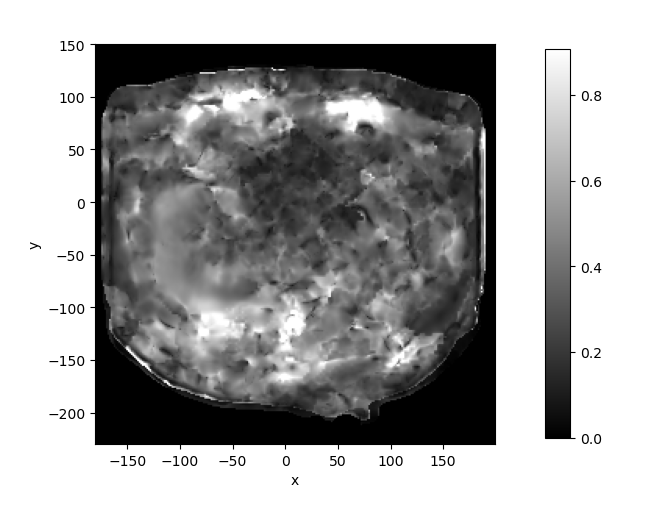

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [44]:
cohort[1].view(compare=True)